# JAX-CFD channel flow demo

This demonstration shows how to use JAX-CFD to simulate 2d flow between parallel no-slip walls.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import jax_cfd.base as cfd
import xarray

In [2]:
rho = 1.
viscosity = 5e-10 #kinematic viscosity
L = 2
u = 1.75

Re = u*L/viscosity
Re

7000000000.0

In [14]:
#size = (512, 128)
size = (256,64)
domain = ((0, 8), (0, 1))
density = 1.
#viscosity = 1e-3 # kinematic viscosity ### original
viscosity = 1e-5  # kinematic visocity
#pressure_gradient = 2e-3  # uniform dP/dx ### original
pressure_gradient = 2e-2  # uniform dP/dx

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid(size, domain=domain)

# Specify periodic BC on x-boundaries, and no-slip walls on the y-boundaries.
velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

# Specify zero velocity initial conditions
#vx_fn = lambda x, y: jnp.zeros_like(x + y) ### original
#vy_fn = lambda x, y: jnp.zeros_like(x + y) ### original

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)

#vx_fn = lambda x, y: y
#vy_fn = lambda x, y: -x+1


'''
v0 = cfd.initial_conditions.filtered_velocity_field(
    rng_key = jax.random.PRNGKey(11),
    grid = grid,
    iterations = 10
)
'''
pressure_solve = cfd.pressure.solve_fast_diag_channel_flow
v0 = cfd.initial_conditions.initial_velocity_field(
    velocity_fns=(vx_fn, vy_fn),
    grid=grid,
    velocity_bc=velocity_bc,
    pressure_solve=pressure_solve,
    iterations=5)

# Confirm that the divergence of v0 is zero
div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

# Specify a fixed time step based on the convection and diffusion scales
# max_velocity = 1  # value selected from known equilibirum profile ### original
max_velocity = 1
cfl_safety_factor = 0.5

dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

## Testing more ways to initialise this thing so it has zero diveregence


size = (512, 128)
domain = ((0, 8), (0, 2))
density = 1.
#viscosity = 1e-3 # kinematic viscosity ### original
viscosity = 1e-5  # kinematic visocity
#pressure_gradient = 2e-3  # uniform dP/dx ### original
pressure_gradient = 2e-2  # uniform dP/dx

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid(size, domain=domain)

# Specify periodic BC on x-boundaries, and no-slip walls on the y-boundaries.
velocity_bc = (cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
               cfd.boundaries.channel_flow_boundary_conditions(ndim=2))

masks = cfd.grids.domain_interior_masks(grid)

def x_velocity_fn(x, y):
  return jnp.zeros_like(x + y) + 0.2 * np.random.normal(
      size=grid.shape) * masks[0]

def y_velocity_fn(x, y):
  return jnp.zeros_like(x + y) + 0.2 * np.random.normal(
      size=grid.shape) * masks[1]

#pressure_solve=cfd.pressure.solve_fast_diag_channel_flow
pressure_solve = cfd.pressure.solve_cg

v0 = cfd.initial_conditions.initial_velocity_field(
           velocity_fns = (x_velocity_fn, y_velocity_fn),
           grid = grid,
           velocity_bc = velocity_bc,
           pressure_solve = pressure_solve,
           iterations=5)

       



div = cfd.finite_differences.divergence(v0)
np.testing.assert_allclose(div.data, 0)

max_velocity = 1
cfl_safety_factor = 0.5

dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

In [4]:
print(velocity_bc)

(HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('dirichlet', 'dirichlet')), bc_values=((0.0, 0.0), (0.0, 0.0))), HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('dirichlet', 'dirichlet')), bc_values=((0.0, 0.0), (0.0, 0.0))))


In [5]:
# Define a linear force due to the uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):
  
  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))
  
  return forcing

In [6]:
def turbulentForcing(grid):
    #grid = cfd.grids.GridArray(jnp.ones_like(u.data), u.offset, u.grid)
    return cfd.forcings.simple_turbulence_forcing(grid)

In [28]:
# time steps per output
inner_steps = 2000

# number of outputs
outer_steps = 20

# TODO(pnorgaard): Fix Van-Leer limiters for Dirichlet velocity BC 
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)
  
# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve = pressure_solve, # defined above for setting v0
        forcing=pressure_gradient_forcing(pressure_gradient),
        #forcing = turbulentForcing(grid) #try using this to see if it makes the flow turbulent, 
        # it uses kolmogorov forcing
        ),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    step_fn, outer_steps, start_with_input=True))

%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 2min 55s, sys: 19.3 s, total: 3min 14s
Wall time: 1min 17s


In [29]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, outer_steps + 1)
    }
)

# Plot the x-velocity
# ds.pipe(lambda ds: ds.u).plot.imshow(
#    'x', 'y', col='time',cmap=seaborn.cm.rocket, robust=True, col_wrap=4, aspect=2);

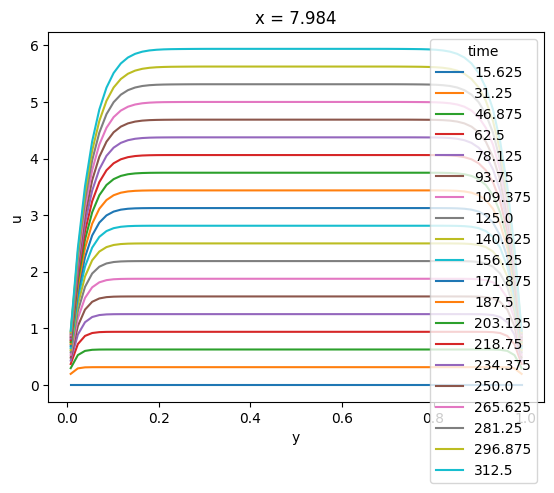

In [30]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time')

/var/tmp/pbs.6907123.pbs/ipykernel_1201703/485083739.py:10: DeprecationWarning: Using positional arguments is deprecated for plot methods, use keyword arguments instead.
  xarray.plot.pcolormesh(u, 'x', 'y',cmap=seaborn.cm.rocket, col_wrap=5,ax=axs[i],robust=True);


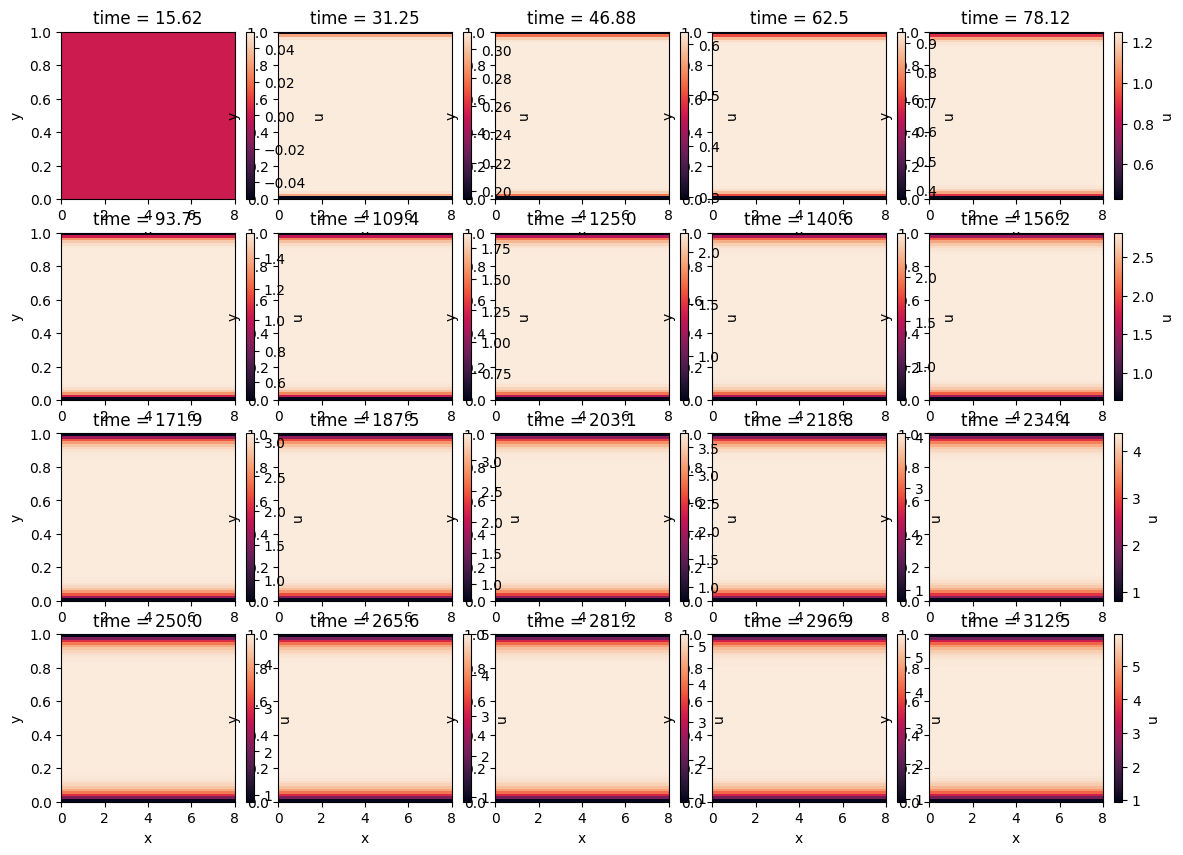

In [31]:

    
    
fig, axs = plt.subplots(4,5, figsize=(14, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()


for i in range(outer_steps):
    u = ds.u[i]
    v = ds.v[i]
    xarray.plot.pcolormesh(u, 'x', 'y',cmap=seaborn.cm.rocket, col_wrap=5,ax=axs[i],robust=True);
    #ds[i].plot.quiver(x='x', y='y', u='u', v='v', ax = axs[i]) 

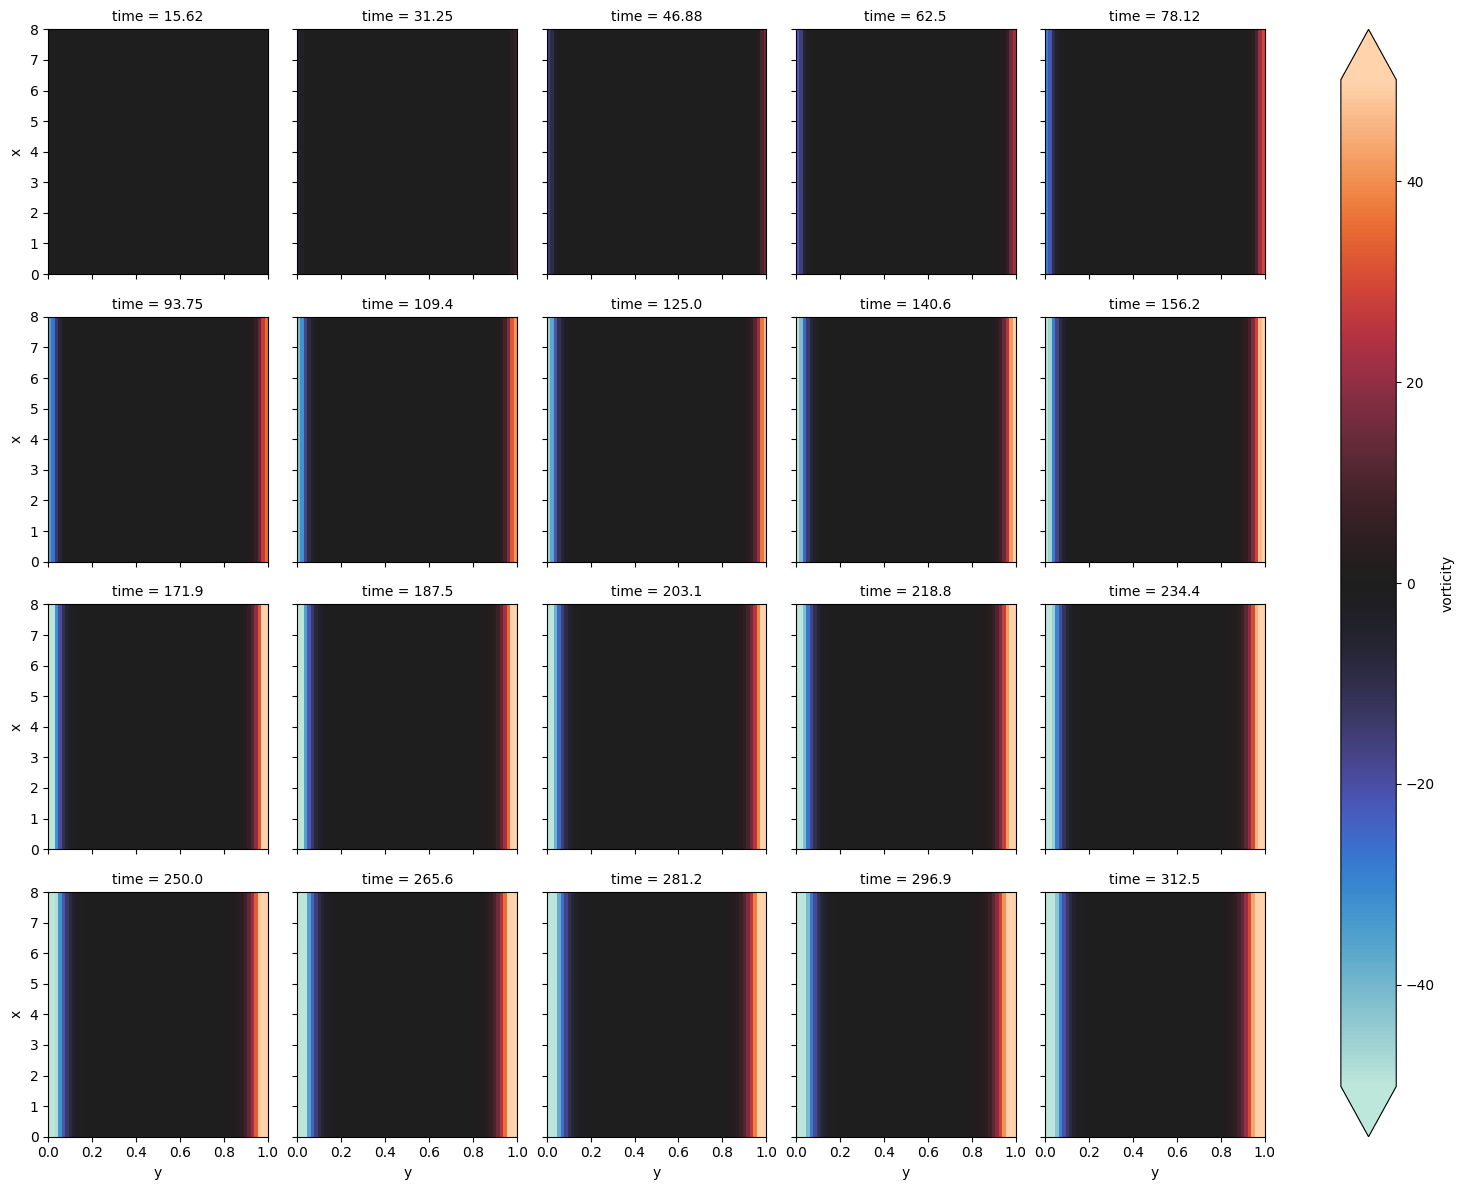

In [33]:

def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

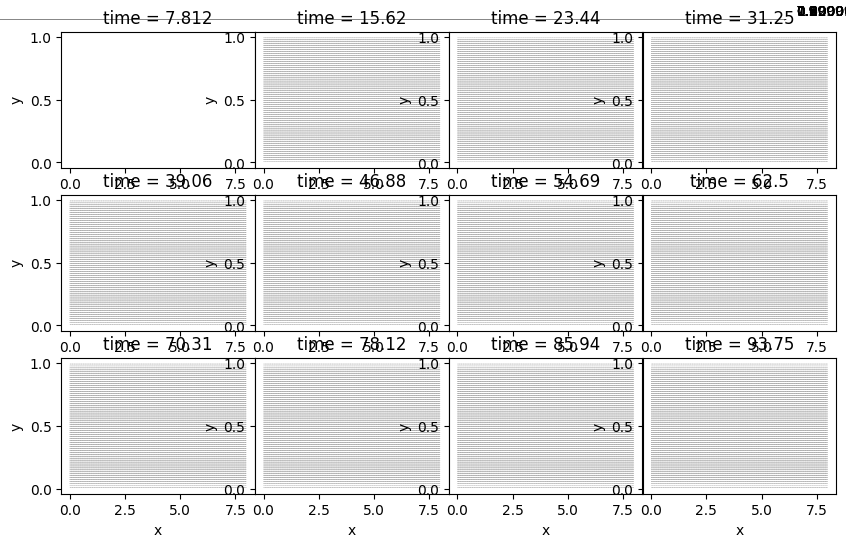

In [21]:
fig, axs = plt.subplots(3,4, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()
for i in range(12):
    ds_plot = ds.isel(time=i)
    ds_plot.plot.quiver(x='x', y='y', u='u', v='v', ax = axs[i], infer_intervals=True)


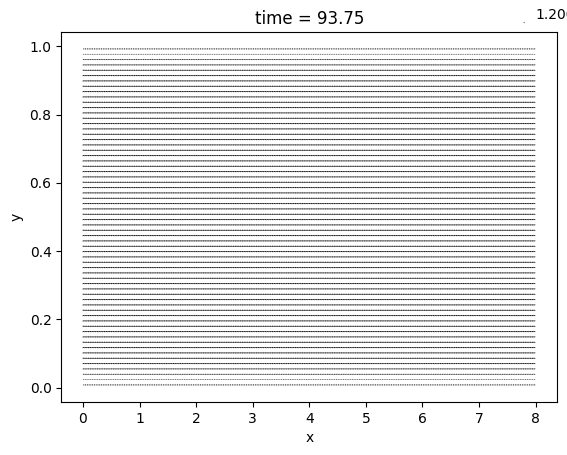

In [22]:
step= 10

(ds.isel(time=11)
 .plot.quiver(x = 'x', y = 'y', u='u', v= 'v', robust=True, infer_intervals=True));